# **INTRODUCTION RESEARCH**


=========================================================================================================
# **PERBANDINGAN KINERJA MODEL ARSITEKTUR PRE-TRAINED TRANSFER LEARNING VGG16, VGG19 DAN ALEXNET PADA ALGORITMA CONVOLUTIONAL NEURAL NETWORK DALAM KLASIFIKASI PENYAKIT PARU-PARU**
=========================================================================================================



**Oleh** : Fahri Aulia Alfarisi Harahap (4193250009)



**Deskripsi Penelitian** : Model ini bertujuan untuk membangun model Convolutional Neural Network (CNN) yang dapat melakukan klasifikasi terhadap 5 jenis penyakit paru-paru, yaitu Bronkitis, BronkoPneumonia, Normal, Tuberculosis dan Pneumonia. Pada penelitian ini digunakan 3 arsitektur transfer learning yaitu VGG16, VGG19 dan Alexnet.

Pada penelitian ini lebih memfokuskan kinerja dari masing-masing arsitektur transfer learning. Uji evaluasi yang akan digunakan adalah Classification report yang terdiri dari accuracy, precision, recall dan f-1 score. Setelah semua nilai didapatkan dari masing-masing arsitektur, terakhir dilakukan perbandingan kinerja dari masing-masing arsitektur transfer learning

======================================================================

Skenario dataset yang dipakai adalah sebagai berikut :

- 1250 dataset yang terdiri dari 5 kelas, masing-masing kelas memiliki 250 dataset.
- Digunakan 80% sebagai dataset train dan 20% sebagai dataset test
- Dataset train akan dilakukan proses augmentasi data
- Data uji diluar data train dan data testing akan digunakan sebanyak 50 buah, masing-masing 10 buah tiap kelas

In [1]:
# Install semua library yang diperlukan, pada penelitian ini digunakan library tensorflow dalam membuat model penelitian

import tensorflow
from tensorflow import keras
import os
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
print("Versi Tensorflow : ", tensorflow.__version__)
print("Versi Keras      : ", keras.__version__)

Versi Tensorflow :  2.12.0
Versi Keras      :  2.12.0


# **0. LOAD DATA**

### **0-1. LOAD DATASET DARI GOOGLE COLAB**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
train_dir = '/content/drive/MyDrive/@SKRIPSI/REVISI/SPLIT DATASET/TRAIN'
test_dir = '/content/drive/MyDrive/@SKRIPSI/REVISI/SPLIT DATASET/TEST'


os.listdir('/content/drive/MyDrive/@SKRIPSI/REVISI/SPLIT DATASET/TEST')


['BRONKITIS', 'PNEUMONIA', 'TUBERCULOSIS', 'BRONKOPNEUMONIA', 'NORMAL']

### **0-2. PLOTTING PEMBAGIAN DATASET TRAIN DAN TESTING**

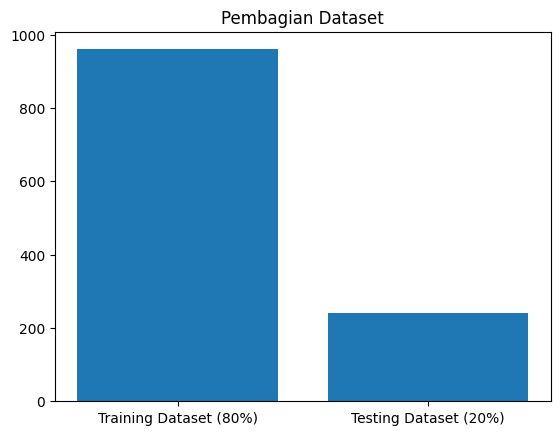

In [ ]:
import matplotlib.pyplot as plt
sum_dataset = 1200
data1 = 80/100 * (sum_dataset)
data2 = 20/100 * (sum_dataset)

labels = ['Training Dataset (80%)', 'Testing Dataset (20%)']
values = [data1, data2]

plt.bar(labels, values)
plt.title('Pembagian Dataset')
plt.show()


### **0-3. PLOTTING DATASET TRAIN DARI SEMUA KELAS**

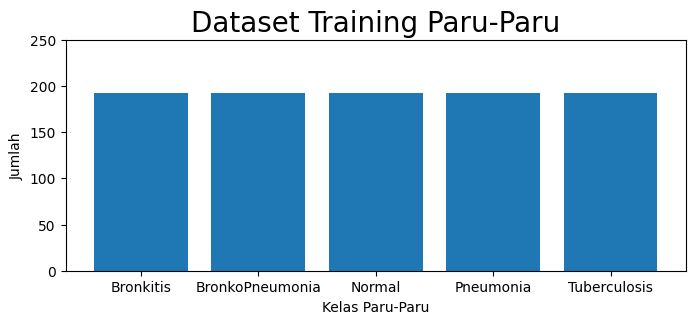

In [ ]:
import os
import matplotlib.pyplot as plt

# Mendefinisikan path direktori
path = train_dir

# Menginisialisasi list untuk menyimpan jumlah gambar dalam setiap file
num_images = []

# Looping melalui setiap direktori dan menghitung jumlah gambar
for directory in os.listdir(path):
    num_images.append(len(os.listdir(os.path.join(path, directory))))

# Membuat plot bar chart
fig, ax = plt.subplots(figsize=(8, 3)) # set ukuran figure menjadi 12x12
ax.bar(range(len(num_images)), num_images)

# Menambahkan label pada sumbu x
ax.set_xticks(range(len(num_images)))
ax.set_xticklabels(['Bronkitis', 'BronkoPneumonia', 'Normal', 'Pneumonia', 'Tuberculosis'])
ax.set_ylim([0, 250])

ax.set_xlabel('Kelas Paru-Paru')
ax.set_ylabel('Jumlah')
ax.set_title('Dataset Training Paru-Paru', fontsize=20)

# Menampilkan plot
plt.show()


### **0-4. PLOTTING DATASET TESTING DARI SEMUA KELAS**

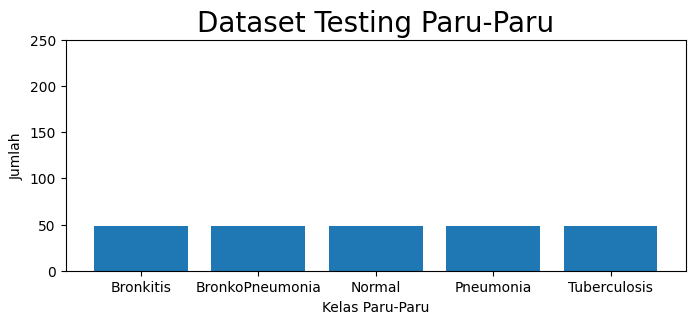

In [ ]:
# Mendefinisikan path direktori
path = test_dir

# Menginisialisasi list untuk menyimpan jumlah gambar dalam setiap file
num_images = []

# Looping melalui setiap direktori dan menghitung jumlah gambar
for directory in os.listdir(path):
    num_images.append(len(os.listdir(os.path.join(path, directory))))

# Membuat plot bar chart
fig, ax = plt.subplots(figsize=(8, 3)) # set ukuran figure menjadi 12x12
ax.bar(range(len(num_images)), num_images)

# Menambahkan label pada sumbu x
ax.set_xticks(range(len(num_images)))
ax.set_xticklabels(['Bronkitis', 'BronkoPneumonia', 'Normal', 'Pneumonia', 'Tuberculosis'])
ax.set_ylim([0, 250])

ax.set_xlabel('Kelas Paru-Paru')
ax.set_ylabel('Jumlah')
ax.set_title('Dataset Testing Paru-Paru', fontsize=20)

# Menampilkan plot
plt.show()

# **1. PRE-PROCESSING DATA**

### **1-1.PRE-PROCESSING DATA GAMBAR TRAINING**
- Sebelumnya semua data citra sudah diubah ke bentuk **binary thresholding**
- Pada proses ini semua dataset citra diubah menjadi ukuran **224x224** piksel
- Proses ini juga dilakukan **augmentasi** data citra pada data citra training. pada proses augmentasi citra digunakan **rotation angle sebesar 15 derajat**, **scale sebesar 20%** dan **shear sebesar 10%**. Rotation angle akan melakukan rotasi dengan maksimum pada citra sebesar 15 derajat, kemudian scale akan melakukan perbesaran dan perkecilan sebesar 20% dan shear akan melakukan pergeseran gambar secara horizontal dan vertikal sebesar 10% dari tinggi dan lebar gambar.

In [ ]:
import os
import cv2
import numpy as np
import random

img_size_alexnet = 224
target_data_size = 5000

def load_images_from_folder(folder_path):
    categories = ['TUBERCULOSIS', 'BRONKITIS', 'NORMAL', 'BRONKOPNEUMONIA', 'PNEUMONIA']
    imageData = []
    data_count = 0

    while data_count < target_data_size:
        for category in categories:
            path = os.path.join(folder_path, category)
            class_num = categories.index(category)
            for img in os.listdir(path):
                img_array = cv2.imread(os.path.join(path, img))
                img_convert = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                img_resize = cv2.resize(img_convert, (img_size_alexnet, img_size_alexnet))
                imageData.append([img_resize, class_num])
                data_count += 1

                if data_count >= target_data_size:
                    break

                # Menambahkan augmentasi gambar
                img_aug = img_resize.copy()
                rotation_angle = random.uniform(-15, 15)
                scale = random.uniform(0.8, 1.2)
                shear = random.uniform(-0.1, 0.1)
                M = cv2.getRotationMatrix2D((img_size_alexnet/2, img_size_alexnet/2), rotation_angle, scale)
                img_aug = cv2.warpAffine(img_aug, M, (img_size_alexnet, img_size_alexnet), borderMode=cv2.BORDER_REFLECT_101)
                img_aug = cv2.resize(img_aug, (img_size_alexnet, img_size_alexnet))
                img_aug = cv2.warpAffine(img_aug, np.float32([[1, shear, 0], [0, 1, 0]]), (img_size_alexnet, img_size_alexnet), borderMode=cv2.BORDER_REFLECT_101)

                # Flip horizontal
                if random.random() < 0.5:
                    img_aug = cv2.flip(img_aug, 1)

                imageData.append([img_aug, class_num])
                data_count += 1

            if data_count >= target_data_size:
                break

    return imageData



### **1-2.PRE-PROCESSING DATA GAMBAR Testing**

- Pada proses ini semua dataset citra diubah menjadi ukuran 224x224 piksel
- Pre-processing data gambar testing **TIDAK DILAKUKAN PROSES AUGMENTASI GAMBAR**

In [ ]:
def load_images_from_folder_test(folder_path):
    categories = ['TUBERCULOSIS', 'BRONKITIS', 'NORMAL', 'BRONKOPNEUMONIA', 'PNEUMONIA']
    imageData = []
    for category in categories:
        path = os.path.join(folder_path, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img)) # Baca gambar
            img_convert = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB) # Konversi ke RGB
            img_resize = cv2.resize(img_convert, (img_size_alexnet, img_size_alexnet)) # Ubah ukuran gambar menjadi 224x224 piksel
            imageData.append([img_resize, class_num]) # Tambahkan gambar yang sudah diubah ukuran ke imageData

    return imageData

In [ ]:
dataTrain = load_images_from_folder(train_dir) # melakukan image processing pada data train
dataTest = load_images_from_folder_test(test_dir) # melakukan image processing pada data testing
random.seed(10)
random.shuffle(dataTrain) # Shuffle Data Train (jika tidak di shuffle, maka data train akan berurutan mengikuti label

### **1-3. DEFINISIKAN FEATURES (X) & LABELS (y)**

In [ ]:

X_train, y_train, X_test, y_test = [], [], [], []

for features, label in dataTrain:
  X_train.append(features)
  y_train.append(label)

for features, label in dataTest:
  X_test.append(features)
  y_test.append(label)

# -1 di reshape artinya numpy akan menentukan dimensi data yang sesuai secara otomatis
X_train = np.array(X_train).reshape(-1, img_size_alexnet, img_size_alexnet, 3)
y_train = np.asarray(y_train)
X_test = np.array(X_test).reshape(-1, img_size_alexnet, img_size_alexnet, 3)
y_test = np.asarray(y_test)

print("X_train :", X_train.shape)
print("y_train :", y_train.shape)
print("X_test  :", X_test.shape)
print("y_test  :", y_test.shape)

X_train : (5001, 224, 224, 3)
y_train : (5001,)
X_test  : (240, 224, 224, 3)
y_test  : (240,)


### **1-4. FEATURE (X) : NORMALISASI DATA CITRA**

- Pada proses ini semua dataset citra train dibagi dengan 255, alasan dibagi dengan 255 adalah untuk memastikan bahwa data berada dalam rentang nilai yang sama, jika data tidak dalam rentang yang sama , maka model sangat mungkin menghasilkan proses training yang underfitting


In [ ]:
print("Isi array X_train : \n\n", X_train[0])
print("\nIsi Array X_test : \n\n", X_test[0])

def prep_pixels(train, test):
  train_norm = train.astype('float32') #data dikonversi kedalam tipe data float
  test_norm = test.astype('float32')

  train_norm = train_norm / 255.0 #data citra dibagi dengan 255.0 agar mendapatkan range 0-1
  test_norm = test_norm / 255.0

  return train_norm, test_norm

X_train_norm, X_test_norm = prep_pixels(X_train, X_test)

print("\nIsi Array X_train_norm :\n\n", X_train_norm[0])
print("\nIsi Array X_test_norm  :\n\n", X_test_norm[0])

Isi array X_train : 

 [[[  4   4   4]
  [  3   3   3]
  [  6   6   6]
  ...
  [  1   1   1]
  [  0   0   0]
  [  0   0   0]]

 [[230 230 230]
  [ 34  34  34]
  [  9   9   9]
  ...
  [ 13  13  13]
  [  0   0   0]
  [  0   0   0]]

 [[252 252 252]
  [ 64  64  64]
  [  7   7   7]
  ...
  [  1   1   1]
  [  0   0   0]
  [  0   0   0]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]

Isi Array X_test : 

 [[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]


### **1-5. LABELS (y) : ONE HOT ENCODING**

- Pada proses ini digunakan proses ONE HOT ENCODING. one-hot encoding akan mengubah setiap nilai dalam variabel kategori menjadi vektor biner. Setiap vektor biner ini memiliki panjang yang sama dengan jumlah nilai kategori yang unik, dan hanya satu elemen dalam vektor yang bernilai 1, sedangkan elemen lainnya bernilai 0

In [ ]:
print("Isi Array y_train :", y_train)
print("Isi Array y_test  :", y_test)

y_train_encode = to_categorical(y_train)
y_test_encode = to_categorical(y_test)

print("\nIsi Array y_train_encode :\n\n", y_train_encode)
print("\nIsi Array y_test_encode :\n\n", y_test_encode)

Isi Array y_train : [0 2 1 ... 4 0 2]
Isi Array y_test  : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]

Isi Array y_train_encode :

 [[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]

Isi Array y_test_encode :

 [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


### **1-6. Plotting Dataset**

Pada tahap ini ditampilkan beberapa contoh dataset, dataset yang ditampilkan adalah dataset yang dilakukan image processing + augmentasi citra

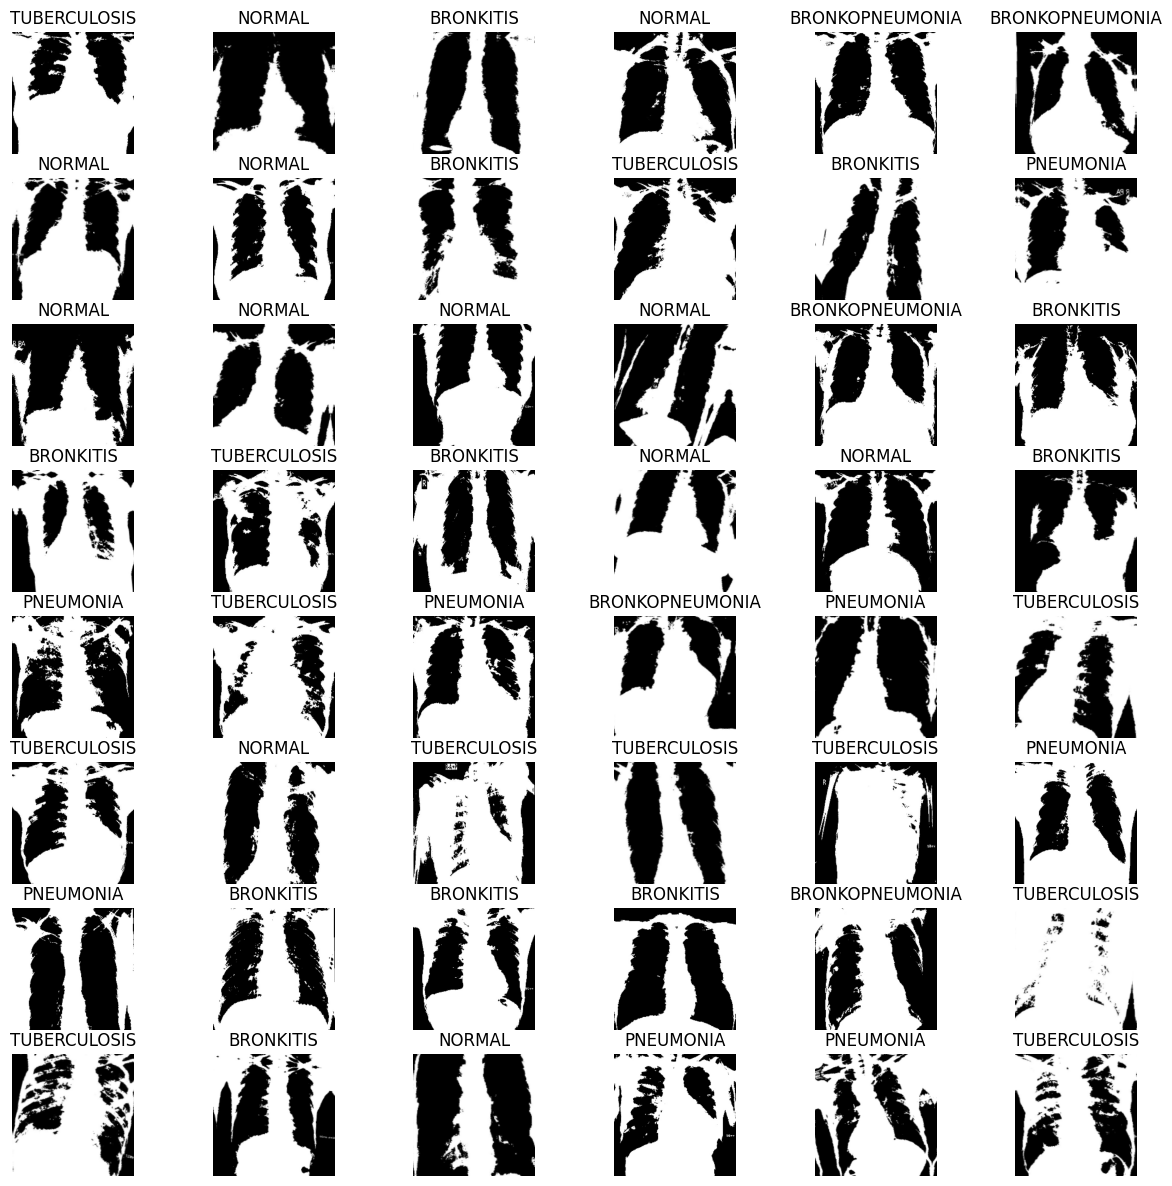

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
nrows = 8
ncols = 6
hspace = 0
wspace = 0
fig, ax = plt.subplots(nrows, ncols, figsize=(13, 13))
fig.subplots_adjust(hspace, wspace)


for i in range(nrows):
  for j in range(ncols):
    temp = i*ncols+j
    ax[i,j].imshow(X_train[temp])
    if y_train[temp] == 0:
      judul = "TUBERCULOSIS"
    elif y_train[temp] == 1:
      judul = "BRONKITIS"
    elif y_train[temp] == 2:
      judul = "NORMAL"
    elif y_train[temp] == 3:
      judul = "BRONKOPNEUMONIA"
    elif y_train[temp] == 4:
      judul = "PNEUMONIA"
    ax[i,j].set_title(judul)
    ax[i,j].axis('off')
plt.show()

### **1-7. DATASET FINAL YANG AKAN DIGUNAKAN**

In [ ]:
import gc

del dataTrain
del dataTest
del X_train
del X_test

gc.collect()

3079

In [ ]:
print("X_train_norm   :", X_train_norm.shape)
print("y_train_encode :", y_train_encode.shape)
print("X_test_norm    :", X_test_norm.shape)
print("y_test_encode  :", y_test_encode.shape)

X_train_norm   : (5001, 224, 224, 3)
y_train_encode : (5001, 5)
X_test_norm    : (240, 224, 224, 3)
y_test_encode  : (240, 5)


# **2. ARSITEKTUR TRANSFER LEARNING**

### **2-1 ARSITEKTUR TRANSFER LEARNING ALEXNET + FULLY CONNECTED LAYER**

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 54, 54, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 26, 26, 256)      1024  

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


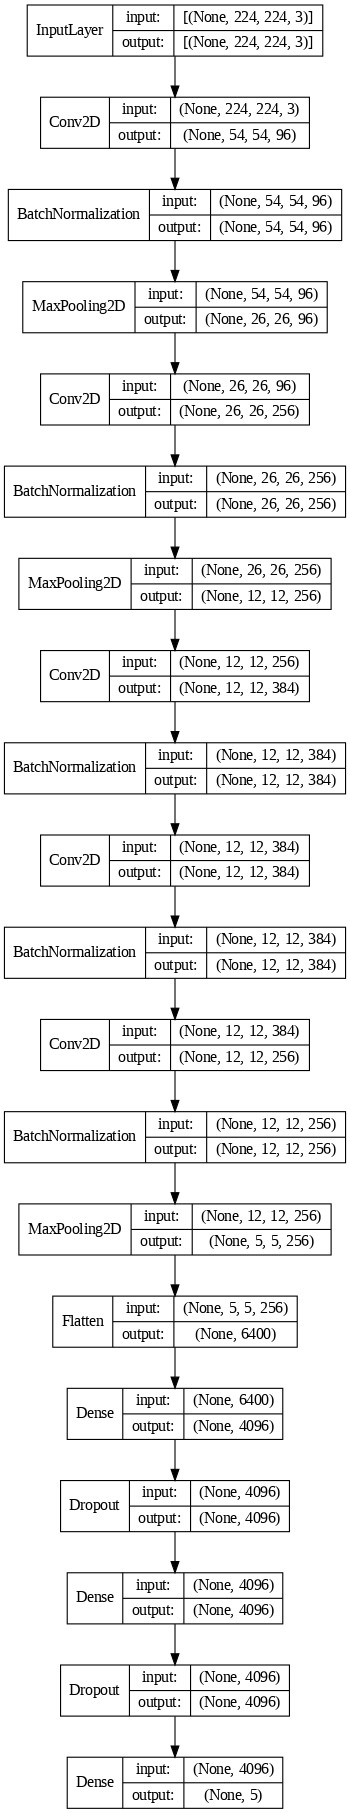

In [2]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras.utils import plot_model
from keras.optimizers import Adam

def define_model_alexnet(img_size_alexnet=224, num_classes=5):
    input_layer = Input(shape=(img_size_alexnet, img_size_alexnet, 3))

    # Layer 1
    x = Conv2D(96, (11, 11), strides=(4, 4), padding='valid', activation='relu')(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)

    # Layer 2
    x = Conv2D(256, (5, 5), strides=(1, 1), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)

    # Layer 3
    x = Conv2D(384, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    # Layer 4
    x = Conv2D(384, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    # Layer 5
    x = Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)

    # Layer 6
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Layer 7
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Output layer
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    opt = Adam(lr=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

model = define_model_alexnet()
model.summary()
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=False, dpi=80 )

# **3. TRAINING MODEL**

### **3-1 Proses Training Dataset**

Pada tahap proses training dataset, digunakan batch size dengan nilai sebesar 32, serta epoch pelatihan sebesar 50 epoch

In [ ]:
%%time

import pandas as pd

epochs = 50
batch_size = 32

history = model.fit(X_train_norm, y_train_encode, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test_norm, y_test_encode))


Epoch 1/50
157/157 [==============================] - 20s 55ms/step - loss: 5.1297 - accuracy: 0.3465 - val_loss: 1.6968 - val_accuracy: 0.2625
Epoch 2/50
157/157 [==============================] - 8s 48ms/step - loss: 1.5129 - accuracy: 0.4101 - val_loss: 1.5290 - val_accuracy: 0.3583
Epoch 3/50
157/157 [==============================] - 7s 46ms/step - loss: 1.4377 - accuracy: 0.4257 - val_loss: 1.4901 - val_accuracy: 0.3708
Epoch 4/50
157/157 [==============================] - 8s 49ms/step - loss: 1.3953 - accuracy: 0.4487 - val_loss: 1.6356 - val_accuracy: 0.3958
Epoch 5/50
157/157 [==============================] - 7s 45ms/step - loss: 1.3521 - accuracy: 0.4643 - val_loss: 1.6434 - val_accuracy: 0.2583
Epoch 6/50
157/157 [==============================] - 8s 48ms/step - loss: 1.2766 - accuracy: 0.4873 - val_loss: 1.4205 - val_accuracy: 0.4458
Epoch 7/50
157/157 [==============================] - 7s 46ms/step - loss: 1.2436 - accuracy: 0.5003 - val_loss: 1.5572 - val_accuracy: 0.312

### **3-2 Plotting Hasil Training Model**

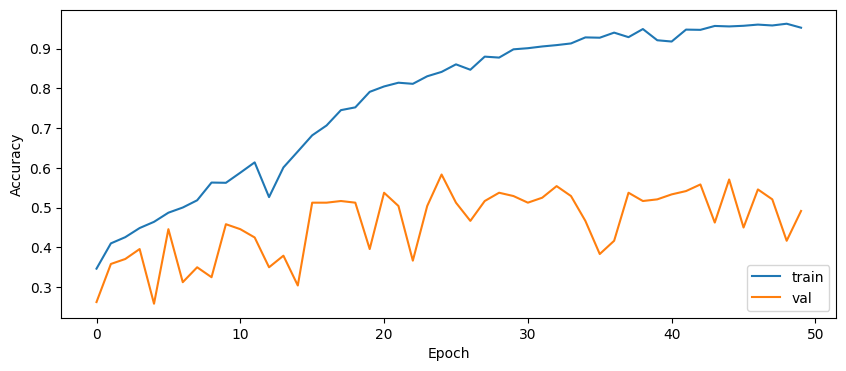

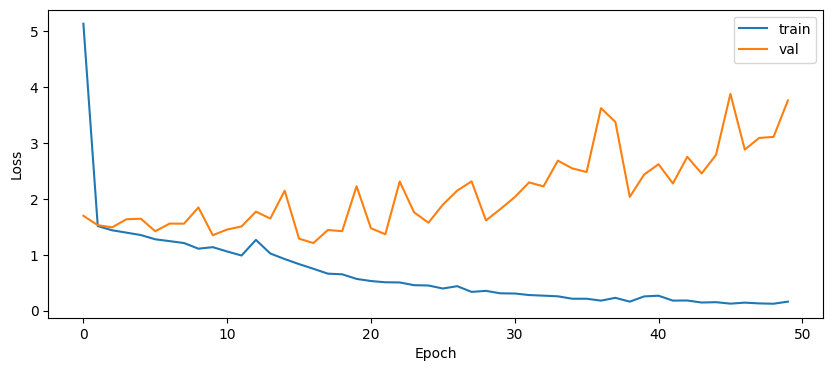

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.legend(['train', 'val'], loc='lower right')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['train', 'val'], loc='upper right')
plt.show()

# **4. EVALUASI MODEL**

### **4-1 Save dan Load Model**

model disave dengan format h5

In [ ]:
model.save("/content/drive/MyDrive/@SKRIPSI/REVISI/Simpan Model/Model_Alexnet.h5")


In [ ]:
model = tensorflow.keras.models.load_model('/content/drive/MyDrive/@SKRIPSI/REVISI/Simpan Model/Model_Alexnet.h5')

### **4-2 Testing Model**

Uji Akurasi Model

In [ ]:
from sklearn.preprocessing import LabelBinarizer

encoder             = LabelBinarizer()
y_train_encode_new  = encoder.fit_transform(y_train)
y_test_encode_new   = encoder.fit_transform(y_test)

pred = model.predict(X_test_norm.astype('float32'), verbose=0)

# mengambil nilai kelas dengan menggunakan argmax()
pred_label = np.argmax(pred, axis=1)

# memproses label asli dari format one-hot encoding menjadi nilai integer
true_label = np.argmax(y_test_encode_new, axis=1)


print("Label Prediksi   :", pred_label)
print("Label Sebenarya  :", true_label, "\n")
loss, acc = model.evaluate(X_test_norm, y_test_encode_new, verbose=1)

Label Prediksi   : [0 2 0 3 0 3 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 4 4 4 0 4 2 0 0 0 0 0 0 3 2 4
 2 4 0 3 0 0 2 0 0 2 0 3 3 3 3 4 4 4 3 1 3 3 3 1 1 3 3 1 1 3 1 4 3 4 3 4 3
 4 3 1 3 4 4 1 4 4 0 3 3 3 1 3 3 4 1 1 3 1 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 0 2 3 2 2 2 2 3 2 2 3 2 2 2 2 2 4 2 2 2 4 2 2 0 2 2 3 3 2 2 2 2 1 3 4 1
 1 3 3 3 1 1 4 1 1 4 1 4 3 3 3 3 4 3 4 1 3 4 1 3 4 1 2 1 4 1 4 1 4 3 3 3 1
 1 1 4 1 1 4 3 3 3 3 4 4 3 1 3 4 3 3 4 3 3 3 2 1 4 4 3 4 3 3 4 4 3 4 3 3 1
 3 4 4 4 4 4 3 4 1 3 4 3 0 4 4 4 3 4]
Label Sebenarya  : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4

### **4-3 Evaluasi Model Dengan Confusion Matrix**

Pada tahap ini model akan di evaluasi berdasarkan 4 nilai, yaitu akurasi, precision, recall dan f-1 score

- Untuk nilai precision, dihitung dari masing-masing kelas
- Untuk nilai recall, dihitung dari masing-masing kelas
- Untuk nilai f-1 score, dihitung dari masing-masing kelas

Accuracy : 49.17%
Loss     : 3.759

Classification Report :

                 precision    recall  f1-score   support

   TUBERCULOSIS       0.89      0.65      0.75        48
      BRONKITIS       0.34      0.25      0.29        48
         NORMAL       0.83      0.81      0.82        48
BRONKOPNEUMONIA       0.22      0.31      0.26        48
      PNEUMONIA       0.38      0.44      0.41        48

       accuracy                           0.49       240
      macro avg       0.53      0.49      0.50       240
   weighted avg       0.53      0.49      0.50       240



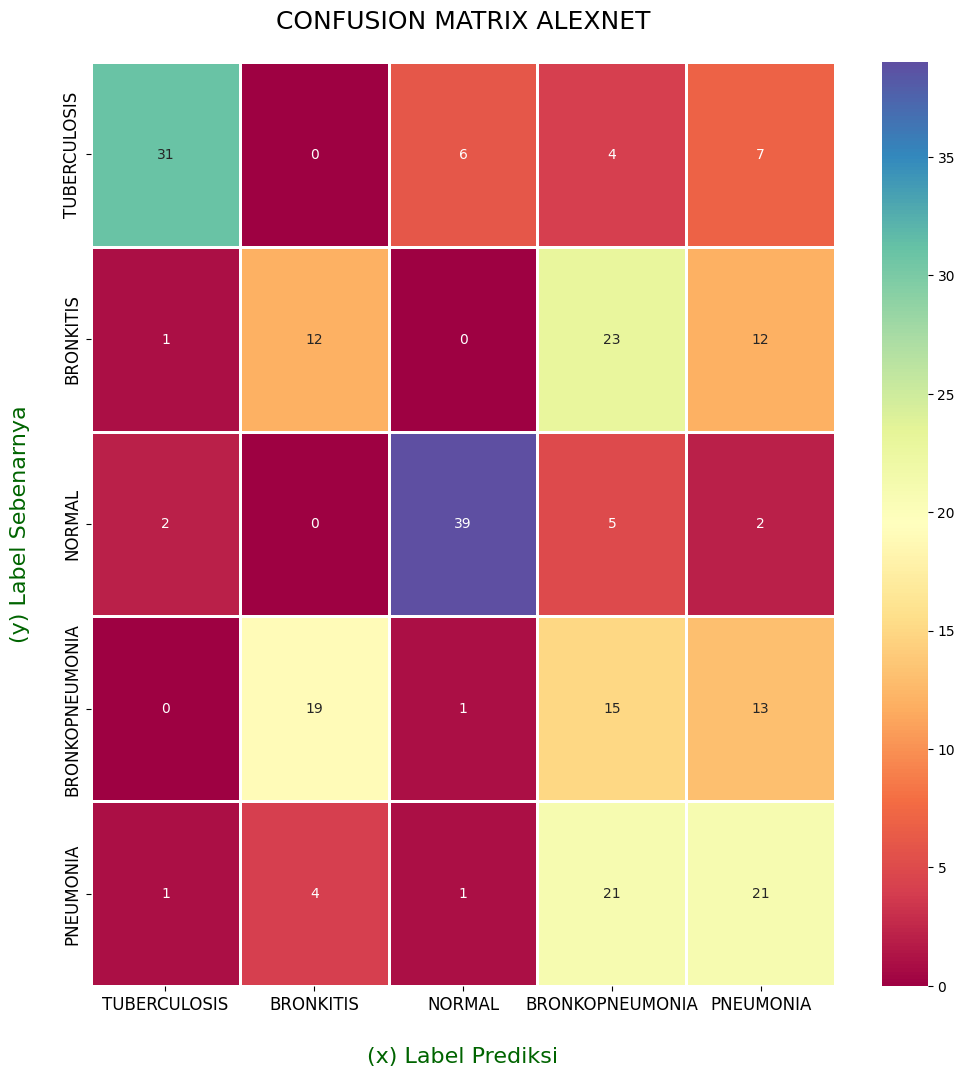

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

target_names = ['TUBERCULOSIS', 'BRONKITIS', 'NORMAL', 'BRONKOPNEUMONIA', 'PNEUMONIA']
cmatrix = confusion_matrix(true_label, pred_label)
creport = classification_report(true_label, pred_label, target_names=target_names)

print("Accuracy : {:.2f}%".format(acc*100))
print("Loss     : {:.3f}".format(loss))

print("\nClassification Report :\n")
print(creport)

fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(cmatrix, cmap="Spectral", annot=True, fmt='.4g', linewidths=2, linecolor='white', cbar=True, ax=ax)

ax.set_title('CONFUSION MATRIX ALEXNET', fontsize=18, pad=24)
ax.set_xticklabels(labels=target_names, fontsize=12)
ax.set_yticklabels(labels=target_names, fontsize=12)

plt.xlabel("(x) Label Prediksi", fontsize=16, color="darkgreen", labelpad=24)
plt.ylabel("(y) Label Sebenarnya", fontsize=16, color="darkgreen", labelpad=24)
plt.show()

# **5. UJI MODEL DENGAN DATA BARU**

Pada tahap ini model diuji dengan menggunakan data baru yaitu data diluar data train dan data test. Data luar sebelumnya sudah dilakukan image processing binary thresholding. Pada Uji data luar ini digunakan 50 data gambar yang mana tiap kelas memiliki 10 data kelas

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import numpy as np

# load and prepare the image
def load_image(filename, img_size_vgg16):
    img = load_img(filename, target_size=(img_size_vgg16, img_size_vgg16))
    img = img_to_array(img)
    img = img.reshape(-1, img_size_vgg16, img_size_vgg16, 3)
    img = img.astype('float32')
    img = img / 255.0
    return img

# load model
model = load_model('/content/drive/MyDrive/@SKRIPSI/REVISI/Simpan Model/Model_Alexnet.h5')

# load an image and predict the class
def run_example(image_paths, img_size_vgg16=224):
    class_names = ['TUBECULOSIS', 'BRONKITIS', 'NORMAL', 'BRONKOPNEUMONIA', 'PNEUMONIA']

    for path in image_paths:
        # load the image
        img = load_image(path, img_size_vgg16)

        # predict the class
        predictions = model.predict(img)
        result = np.argmax(predictions, axis=-1)

        print(f"\nGambar: {path}")
        print("Hasil Prediksi:", class_names[result[0]])

        # Print probabilities of each class
        print("Probabilitas klasifikasi:")
        for i, prob in enumerate(predictions[0]):
            prob_str = "{:.4f}".format(prob)
            print(f"{class_names[i]}:".ljust(20), prob_str)



1. Pengujian Model dengan data kelas Bronkitis

In [ ]:
import os
def generate_image_paths(folder_path, class_name, start_num, end_num):
    image_paths = []
    for num in range(start_num, end_num + 1):
        filename = f"{class_name}-{num}.jpg"
        full_path = os.path.join(folder_path, filename)
        image_paths.append(full_path)
    return image_paths

# Example usage
folder_path = '/content/drive/MyDrive/@SKRIPSI/REVISI/SPLIT DATASET/data UJI MODEL'
class_name = 'BRONKITIS'
start_num = 241
end_num = 250
image_paths = generate_image_paths(folder_path, class_name, start_num, end_num)
run_example(image_paths)


1/1 [==============================] - 1s 788ms/step

Gambar: /content/drive/MyDrive/@SKRIPSI/REVISI/SPLIT DATASET/data UJI MODEL/BRONKITIS-241.jpg
Hasil Prediksi: TUBECULOSIS
Probabilitas klasifikasi:
TUBECULOSIS:         0.3079
BRONKITIS:           0.2249
NORMAL:              0.2848
BRONKOPNEUMONIA:     0.0855
PNEUMONIA:           0.0969
1/1 [==============================] - 0s 23ms/step

Gambar: /content/drive/MyDrive/@SKRIPSI/REVISI/SPLIT DATASET/data UJI MODEL/BRONKITIS-242.jpg
Hasil Prediksi: PNEUMONIA
Probabilitas klasifikasi:
TUBECULOSIS:         0.0000
BRONKITIS:           0.0000
NORMAL:              0.0000
BRONKOPNEUMONIA:     0.0000
PNEUMONIA:           1.0000
1/1 [==============================] - 0s 30ms/step

Gambar: /content/drive/MyDrive/@SKRIPSI/REVISI/SPLIT DATASET/data UJI MODEL/BRONKITIS-243.jpg
Hasil Prediksi: BRONKOPNEUMONIA
Probabilitas klasifikasi:
TUBECULOSIS:         0.0000
BRONKITIS:           0.0000
NORMAL:              0.0000
BRONKOPNEUMONIA:     1.0000
PN

2. Pengujian Model dengan data kelas Tuberculosis

In [ ]:
import os
def generate_image_paths(folder_path, class_name, start_num, end_num):
    image_paths = []
    for num in range(start_num, end_num + 1):
        filename = f"{class_name}-{num}.jpg"
        full_path = os.path.join(folder_path, filename)
        image_paths.append(full_path)
    return image_paths

# Example usage
folder_path = '/content/drive/MyDrive/@SKRIPSI/REVISI/SPLIT DATASET/data UJI MODEL'
class_name = 'TUBERCULOSIS'
start_num = 241
end_num = 250
image_paths = generate_image_paths(folder_path, class_name, start_num, end_num)
run_example(image_paths)


1/1 [==============================] - 0s 28ms/step

Gambar: /content/drive/MyDrive/@SKRIPSI/REVISI/SPLIT DATASET/data UJI MODEL/TUBERCULOSIS-241.jpg
Hasil Prediksi: BRONKOPNEUMONIA
Probabilitas klasifikasi:
TUBECULOSIS:         0.0010
BRONKITIS:           0.0575
NORMAL:              0.0046
BRONKOPNEUMONIA:     0.8700
PNEUMONIA:           0.0668
1/1 [==============================] - 0s 28ms/step

Gambar: /content/drive/MyDrive/@SKRIPSI/REVISI/SPLIT DATASET/data UJI MODEL/TUBERCULOSIS-242.jpg
Hasil Prediksi: PNEUMONIA
Probabilitas klasifikasi:
TUBECULOSIS:         0.0238
BRONKITIS:           0.0320
NORMAL:              0.0187
BRONKOPNEUMONIA:     0.4605
PNEUMONIA:           0.4650
1/1 [==============================] - 0s 33ms/step

Gambar: /content/drive/MyDrive/@SKRIPSI/REVISI/SPLIT DATASET/data UJI MODEL/TUBERCULOSIS-243.jpg
Hasil Prediksi: PNEUMONIA
Probabilitas klasifikasi:
TUBECULOSIS:         0.0000
BRONKITIS:           0.0000
NORMAL:              0.0000
BRONKOPNEUMONIA:     0.0

3. Pengujian Model dengan data kelas Normal

In [ ]:
import os
def generate_image_paths(folder_path, class_name, start_num, end_num):
    image_paths = []
    for num in range(start_num, end_num + 1):
        filename = f"{class_name}-{num}.jpg"
        full_path = os.path.join(folder_path, filename)
        image_paths.append(full_path)
    return image_paths

# Example usage
folder_path = '/content/drive/MyDrive/@SKRIPSI/REVISI/SPLIT DATASET/data UJI MODEL'
class_name = 'NORMAL'
start_num = 241
end_num = 250
image_paths = generate_image_paths(folder_path, class_name, start_num, end_num)
run_example(image_paths)


1/1 [==============================] - 0s 20ms/step

Gambar: /content/drive/MyDrive/@SKRIPSI/REVISI/SPLIT DATASET/data UJI MODEL/NORMAL-241.jpg
Hasil Prediksi: NORMAL
Probabilitas klasifikasi:
TUBECULOSIS:         0.0000
BRONKITIS:           0.0000
NORMAL:              1.0000
BRONKOPNEUMONIA:     0.0000
PNEUMONIA:           0.0000
1/1 [==============================] - 0s 21ms/step

Gambar: /content/drive/MyDrive/@SKRIPSI/REVISI/SPLIT DATASET/data UJI MODEL/NORMAL-242.jpg
Hasil Prediksi: NORMAL
Probabilitas klasifikasi:
TUBECULOSIS:         0.0041
BRONKITIS:           0.0010
NORMAL:              0.9766
BRONKOPNEUMONIA:     0.0008
PNEUMONIA:           0.0175
1/1 [==============================] - 0s 29ms/step

Gambar: /content/drive/MyDrive/@SKRIPSI/REVISI/SPLIT DATASET/data UJI MODEL/NORMAL-243.jpg
Hasil Prediksi: NORMAL
Probabilitas klasifikasi:
TUBECULOSIS:         0.0000
BRONKITIS:           0.0000
NORMAL:              1.0000
BRONKOPNEUMONIA:     0.0000
PNEUMONIA:           0.0000
1

4. Pengujian Model dengan data kelas BronkoPneumonia

In [ ]:
import os
def generate_image_paths(folder_path, class_name, start_num, end_num):
    image_paths = []
    for num in range(start_num, end_num + 1):
        filename = f"{class_name}-{num}.jpg"
        full_path = os.path.join(folder_path, filename)
        image_paths.append(full_path)
    return image_paths

# Example usage
folder_path = '/content/drive/MyDrive/@SKRIPSI/REVISI/SPLIT DATASET/data UJI MODEL'
class_name = 'BRONKOPNEUMONIA'
start_num = 241
end_num = 250
image_paths = generate_image_paths(folder_path, class_name, start_num, end_num)
run_example(image_paths)


1/1 [==============================] - 0s 20ms/step

Gambar: /content/drive/MyDrive/@SKRIPSI/REVISI/SPLIT DATASET/data UJI MODEL/BRONKOPNEUMONIA-241.jpg
Hasil Prediksi: PNEUMONIA
Probabilitas klasifikasi:
TUBECULOSIS:         0.0000
BRONKITIS:           0.0000
NORMAL:              0.0000
BRONKOPNEUMONIA:     0.0000
PNEUMONIA:           1.0000
1/1 [==============================] - 0s 18ms/step

Gambar: /content/drive/MyDrive/@SKRIPSI/REVISI/SPLIT DATASET/data UJI MODEL/BRONKOPNEUMONIA-242.jpg
Hasil Prediksi: BRONKOPNEUMONIA
Probabilitas klasifikasi:
TUBECULOSIS:         0.0000
BRONKITIS:           0.0000
NORMAL:              0.0000
BRONKOPNEUMONIA:     1.0000
PNEUMONIA:           0.0000
1/1 [==============================] - 0s 20ms/step

Gambar: /content/drive/MyDrive/@SKRIPSI/REVISI/SPLIT DATASET/data UJI MODEL/BRONKOPNEUMONIA-243.jpg
Hasil Prediksi: BRONKOPNEUMONIA
Probabilitas klasifikasi:
TUBECULOSIS:         0.0000
BRONKITIS:           0.0036
NORMAL:              0.0000
BRONKOPNE

5. Pengujian Model dengan data kelas Pneumonia

In [ ]:
import os
def generate_image_paths(folder_path, class_name, start_num, end_num):
    image_paths = []
    for num in range(start_num, end_num + 1):
        filename = f"{class_name}-{num}.jpg"
        full_path = os.path.join(folder_path, filename)
        image_paths.append(full_path)
    return image_paths

# Example usage
folder_path = '/content/drive/MyDrive/@SKRIPSI/REVISI/SPLIT DATASET/data UJI MODEL'
class_name = 'PNEUMONIA'
start_num = 241
end_num = 250
image_paths = generate_image_paths(folder_path, class_name, start_num, end_num)
run_example(image_paths)


1/1 [==============================] - 0s 19ms/step

Gambar: /content/drive/MyDrive/@SKRIPSI/REVISI/SPLIT DATASET/data UJI MODEL/PNEUMONIA-241.jpg
Hasil Prediksi: BRONKOPNEUMONIA
Probabilitas klasifikasi:
TUBECULOSIS:         0.0000
BRONKITIS:           0.0000
NORMAL:              0.0000
BRONKOPNEUMONIA:     1.0000
PNEUMONIA:           0.0000
1/1 [==============================] - 0s 19ms/step

Gambar: /content/drive/MyDrive/@SKRIPSI/REVISI/SPLIT DATASET/data UJI MODEL/PNEUMONIA-242.jpg
Hasil Prediksi: BRONKOPNEUMONIA
Probabilitas klasifikasi:
TUBECULOSIS:         0.0000
BRONKITIS:           0.0000
NORMAL:              0.0000
BRONKOPNEUMONIA:     1.0000
PNEUMONIA:           0.0000
1/1 [==============================] - 0s 24ms/step

Gambar: /content/drive/MyDrive/@SKRIPSI/REVISI/SPLIT DATASET/data UJI MODEL/PNEUMONIA-243.jpg
Hasil Prediksi: BRONKOPNEUMONIA
Probabilitas klasifikasi:
TUBECULOSIS:         0.0000
BRONKITIS:           0.0000
NORMAL:              0.0000
BRONKOPNEUMONIA:     